# DATA PRE-PROCESSING

In [139]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt

from collections import Counter 

from sklearn.model_selection import GridSearchCV

In [6]:
# Import and touch up ticker data
sp500 = pd.read_csv("Data/SP500.csv")
sp500.set_index('Unnamed: 0', inplace = True)
sp500.index.names = ['date']
sp500.set_index(pd.to_datetime(sp500.index), inplace = True)

sp500[sp500 == np.inf] = 0
sp500[sp500 == -np.inf] = 0

# Remove MMM because it has weird properties
sp500.drop('MMM', axis=1, inplace=True)

In [7]:
# Import and touch up indicator data
sp500_in = pd.read_csv("Data/SP500indicators.csv")
sp500_in.drop('Unnamed: 0', axis=1, inplace = True)
sp500_in.set_index(pd.to_datetime(sp500_in['calendardate']), inplace = True)
sp500_in.index.names = ['date']
sp500_in['year'] = sp500_in.index.year

In [8]:
# Cut down S&P 500 to stocks that existed for 8 years
sp500_cut = sp500.loc[pd.to_datetime('2011-12-30'):,:]
sp500_cut = sp500_cut.dropna(axis =1, how='any')

In [9]:
sp500_ar = sp500_cut.groupby(sp500_cut.index.year).sum().mean(axis=1)
sp500_ar = np.array(sp500_ar)
annual_rets = sp500_cut.groupby(sp500_cut.index.year).sum()
excess_rets = annual_rets.subtract(sp500_ar, axis=0)

excess_rets = excess_rets.reset_index()
excess_rets_melt = pd.melt(excess_rets, id_vars=['date'])
excess_rets_melt.rename(columns={'date':'year',
                                 'value':'excessreturns', 
                                 'variable':'ticker'}, 
                        inplace=True)

In [10]:
excess_rets_melt['year'] = excess_rets_melt['year'] + 1

In [11]:
sp500_prepped = pd.merge(sp500_in, excess_rets_melt, on = ['year','ticker'], how='left')
sp500_prepped = sp500_prepped[np.isfinite(sp500_prepped['excessreturns'])]
sp500_prepped = sp500_prepped.assign(beat = [1 if x > 0 else 0 for x in sp500_prepped['excessreturns']])

In [12]:
sp500_prepped.dropna(how='any', inplace=True)

In [14]:
counts = dict(Counter(sp500_prepped["ticker"]))
full_stock = []
for ticker, num in counts.items():
    if num == 7:
        full_stock.append(ticker)

sp500_prepped = sp500_prepped[sp500_prepped["ticker"].isin(full_stock)]

In [15]:
excludes = ['dimension','calendardate', 'datekey', 
            'reportperiod','lastupdated','year',
            'excessreturns', 'ticker', 'beat']

# Weight the information using date. Figure out how to include.

In [16]:
# Stratified train-test split
X_train = sp500_prepped[sp500_prepped['calendardate'] < '2017-01-01']
y_train = X_train['excessreturns']
X_train.drop(excludes, axis=1, inplace = True)

X_test1 = sp500_prepped[sp500_prepped['calendardate'] == '2017-12-31']
y_test1 = X_test1['excessreturns']
X_test1.drop(excludes, axis=1, inplace = True)

X_test2 = sp500_prepped[sp500_prepped['calendardate'] > '2018-01-01']
y_test2 = X_test2['excessreturns']
X_test2.drop(excludes, axis=1, inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [108]:
sp500_prepped.head(10)

,ticker,dimension,calendardate,datekey,reportperiod,lastupdated,accoci,assets,assetsavg,assetsc,...,sps,tangibles,taxassets,taxexp,taxliabilities,tbvps,workingcapital,year,excessreturns,beat
8,ABT,MRY,2018-12-31,2018-12-31,2018-12-31,2019-05-01,-7.586000e+09,6.717300e+10,6.953325e+10,1.463200e+10,...,17.394,2.497700e+10,1.885000e+09,539000000,3.050000e+08,14.184,5.620000e+09,2018,0.258804,1
9,ABT,MRY,2017-12-31,2017-12-31,2017-12-31,2019-05-01,-6.062000e+09,7.625000e+10,7.263400e+10,2.014700e+10,...,15.741,3.075700e+10,1.944000e+09,1878000000,3.090000e+08,17.595,1.123500e+10,2017,-0.267482,0
10,ABT,MRY,2016-12-31,2016-12-31,2016-12-31,2019-05-01,-7.263000e+09,5.266600e+10,4.290775e+10,2.677600e+10,...,14.118,4.044400e+10,2.263000e+09,350000000,1.880000e+08,27.346,2.011600e+10,2016,0.004223,1
11,ABT,MRY,2015-12-31,2015-12-31,2015-12-31,2019-05-01,-6.658000e+09,4.124700e+10,4.254800e+10,1.415500e+10,...,13.640,2.604700e+10,2.119000e+09,577000000,4.300000e+08,17.513,4.969000e+09,2015,0.012672,1
12,ABT,MRY,2014-12-31,2014-12-31,2014-12-31,2019-05-01,-5.053000e+09,4.120700e+10,4.171450e+10,1.355600e+10,...,13.356,2.494200e+10,3.288000e+09,797000000,2.700000e+08,16.512,3.089000e+09,2014,-0.119017,0
13,ABT,MRY,2013-12-31,2013-12-31,2013-12-31,2019-05-01,-2.012000e+09,4.295300e+10,4.316886e+10,1.924700e+10,...,12.617,2.744600e+10,4.637000e+09,53000000,1.750000e+08,17.697,9.740000e+09,2013,-0.016115,0
14,ABT,MRY,2012-12-31,2012-12-31,2012-12-31,2019-05-01,-3.594000e+09,6.723500e+10,6.369208e+10,3.132300e+10,...,12.095,4.287300e+10,6.199000e+09,-457000000,6.550000e+08,27.193,1.804300e+10,2012,0.002434,1
24,ACN,MRY,2018-12-31,2018-08-31,2018-08-31,2019-03-28,-1.576171e+09,2.444908e+10,2.345175e+10,1.358556e+10,...,66.200,1.906607e+10,2.086807e+09,1593499000,1.580450e+09,29.758,3.433808e+09,2018,0.129629,1
25,ACN,MRY,2017-12-31,2017-08-31,2017-08-31,2019-03-28,-1.094784e+09,2.268989e+10,2.108700e+10,1.209729e+10,...,59.289,1.768754e+10,2.214901e+09,981100000,1.420363e+09,28.651,2.273010e+09,2017,-0.002129,0
26,ACN,MRY,2016-12-31,2016-08-31,2016-08-31,2019-03-28,-1.661720e+09,2.060900e+10,1.898543e+10,1.197622e+10,...,55.694,1.699957e+10,2.077312e+09,1253969000,1.683051e+09,27.308,3.097298e+09,2016,0.163917,1


# Portfolio Optimization

We create portfolios to hedge risk. In this case, I am predicting expected returns, and when I create a portfolio I am functionally ensembling multiple predictions this lowers the variance of my predictions. 

The two functions below do the following:
- Predict returns using model
- Create optimal portfolios using the covariance matrix and predicted returns of all the stocks
- Remove all shorts
- Select the x/2 highest returns and the x/2 lowest returns for each optimal portfolio
- Rebalance the portfolio
- Get the RMSE of all portfolio return predictions

In [124]:
# Function to get the RMSE of all optimal portfolios
# Rules: no short selling, 20 stocks total
def MVA(model, y_train, X_test, y_test):
    cov = np.matrix(np.cov(np.split(y_train,250)))
    exp_returns = model.predict(X_test)

    n1T = [1] * 250
    n1 = np.transpose(n1T)
    V_inv = np.linalg.inv(cov)
    w1 = np.dot(V_inv, exp_returns) / np.dot(np.dot(n1T,V_inv),exp_returns)
    w2 = np.dot(V_inv, n1) / np.dot(np.dot(n1T,V_inv),n1)
    
    port_exp_rets = []
    port_sds = []
    all_actual_returns = []
    all_weights = []
    all_indices = []
    SSE = 0
    count = 0
    
    for p in np.arange(0, 1, .01):
        stock_returns = []
        
        weights = p*w1 + (1-p)*w2
        # Remove short positions
        weights = [0 if i < 0 else i for i in weights.tolist()[0]]
        #  Pick the x/2 highest and the x/2 lowest
        indices, weights = x_high_and_low(weights, 20)
        # Rebalance weights so they equal 1
        total = sum(weights)
        weights = [weight / total for weight in weights]
        
        cov_mat = cov[indices, :]
        cov_mat = cov_mat[:, indices]

        for j in indices:
            stock_returns.append(exp_returns[j])
            
        test = y_test.reset_index().drop('index', axis = 1)
        actual_returns = test.iloc[indices,0]
        
        actual_return = np.dot(weights, actual_returns)
        port_exp_ret = np.dot(weights,stock_returns)
        SSE = SSE + (actual_return - port_exp_ret)**2
        count = count + 1
        
        port_exp_rets.append( port_exp_ret )
        port_sds.append( (np.dot(np.dot(weights,cov_mat), np.transpose(weights))) )
        all_weights.append(weights)
        all_indices.append(indices)
        all_actual_returns.append(actual_returns)
    
    # sharpe_ratio = [x/y for x, y in zip(port_exp_rets, port_sds)]
    # best_portfolio = sharpe_ratio.index(max(sharpe_ratio))
    
    RMSE = np.sqrt(SSE/count)
    
    return RMSE

# Function to get the x/2 highest and x/2 lowest values and indices of a list
def x_high_and_low(lst, x):
    if x % 2 != 0:
        x = x - 1
    x = x // 2
    
    indices = []
    values = []
    
    # x/2 highest
    high = sorted(lst, reverse=True)[:x]
    for i in high:
        indices.append(lst.index(i))
        values.append(i)
    
    # x/2 lowest non-zero
    low = filter(lambda a: a != 0, lst)
    low = sorted(low)[:x]
    for i in low:
        indices.append(lst.index(i))
        values.append(i)
    return indices, values

# DATA ANALYSIS

Using the fundamentals data, I intend to predict the 1 and 2 year ahead stock returns. I believe there is a theoretical basis for using fundamentals because they are data points that directly describe the underlying business of the stock. Assuming the algorithms used are able to find a relationship between the fundamentals and returns, enough high quality data points should eventually get relatively close to predicting the returns of each stock.

## Model Tuning

### Random Forest Regressor

In [69]:
%%time

from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state = 13)
    
rf_param_grid = {
    'max_depth': [50,60,70,80,90],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf_reg_cv = GridSearchCV(estimator=rf_reg, param_grid=rf_param_grid, cv=3, n_jobs=-1)

rf_reg_cv = rf_reg_cv.fit(X_train, y_train)

print(rf_reg_cv.best_params_)

{'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
CPU times: user 5.13 s, sys: 1.3 s, total: 6.43 s
Wall time: 5min 8s


### Gradient Boosting Regressor

In [60]:
%%time

from xgboost import XGBRegressor

xg_reg = XGBRegressor(random_state = 13)

xg_param_grid = {
   'colsample_bytree':[0.4],
   'gamma':[0.03,0.1],
   'min_child_weight':[1.5,3],
   'learning_rate':[0.1],
   'max_depth':[3,5],
   'n_estimators':[50,100,200],
   'reg_alpha':[0.75],
   'reg_lambda':[0.45],
   'subsample':[0.95]  
}

xg_reg_cv = GridSearchCV(estimator=xg_reg, param_grid=xg_param_grid, cv=3, n_jobs=-1)

xg_reg_cv = xg_reg_cv.fit(X_train, y_train)

print(xg_reg_cv.best_params_)

{'colsample_bytree': 0.4, 'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 50, 'reg_alpha': 0.75, 'reg_lambda': 0.45, 'subsample': 0.95}
CPU times: user 459 ms, sys: 151 ms, total: 610 ms
Wall time: 13.2 s


{
    'colsample_bytree': 0.4, 
    'gamma': 0.03, 
    'learning_rate': 0.1, 
    'max_depth': 3, 
    'min_child_weight': 1.5, 
    'n_estimators': 50, 
    'reg_alpha': 0.75, 
    'reg_lambda': 0.45, 
    'subsample': 0.95
}

### KNN Regressor

In [67]:
%%time

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled)

knn_reg = KNeighborsRegressor()

knn_param = {'n_neighbors': np.arange(3,15)}

knn_reg_cv = GridSearchCV(estimator=knn_reg, param_grid=knn_param, cv=5)
knn_reg_cv = knn_reg_cv.fit(X_train_scaled, y_train)

print(knn_reg_cv.best_params_)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


{'n_neighbors': 14}
CPU times: user 9.71 s, sys: 75.1 ms, total: 9.78 s
Wall time: 9.99 s


## Model Testing

### Random Forest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(random_state = 13, max_depth = 50, 
            max_features = 3, min_samples_split = 10,
            n_estimators = 100)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=13,
           verbose=0, warm_start=False)

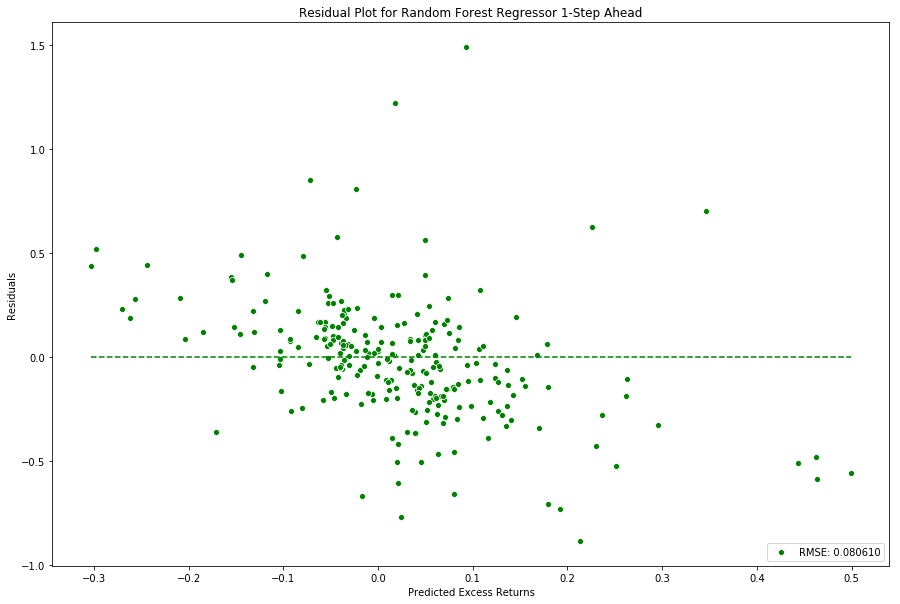

In [186]:
predictions = rf_reg.predict(X_test1)
rmse = MVA(rf_reg, y_train, X_test1, y_test1)
resids = y_test1 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="g", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for Random Forest Regressor 1-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'g')
plt.legend(loc="lower right")
plt.show()

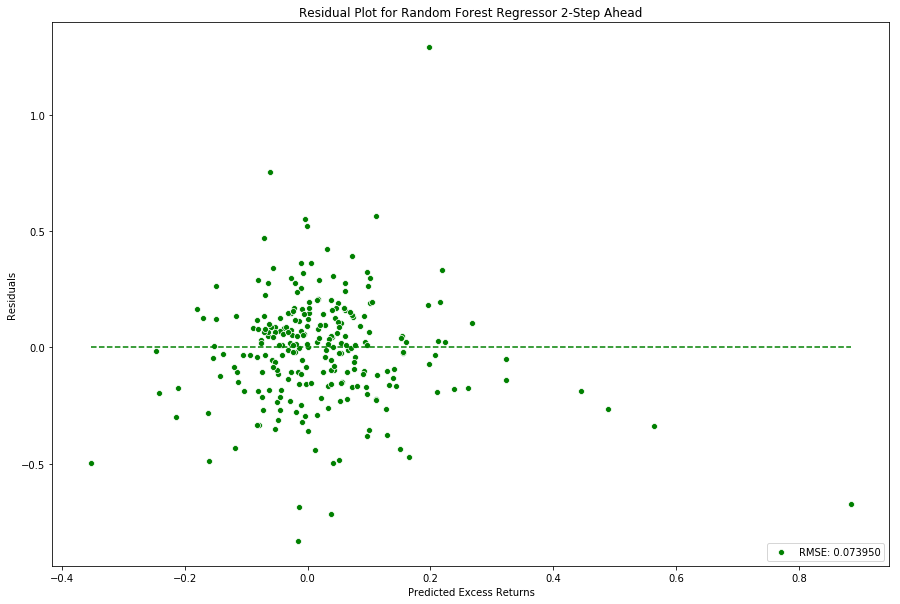

In [185]:
predictions = rf_reg.predict(X_test2)
rmse = MVA(rf_reg, y_train, X_test2, y_test2)
resids = y_test2 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="g", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for Random Forest Regressor 2-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'g')
plt.legend(loc="lower right")
plt.show()

### Gradient Boosting Regressor

In [85]:
from xgboost import XGBRegressor

xg_reg = XGBRegressor(random_state=13, colsample_bytree=0.4, 
            gamma=0.03, learning_rate=0.1,
            max_depth=3, min_child_weight=1.5, 
            n_estimators=50, reg_alpha=0.75, subsample=0.95)

xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.03, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1.5, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=13, reg_alpha=0.75, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.95)

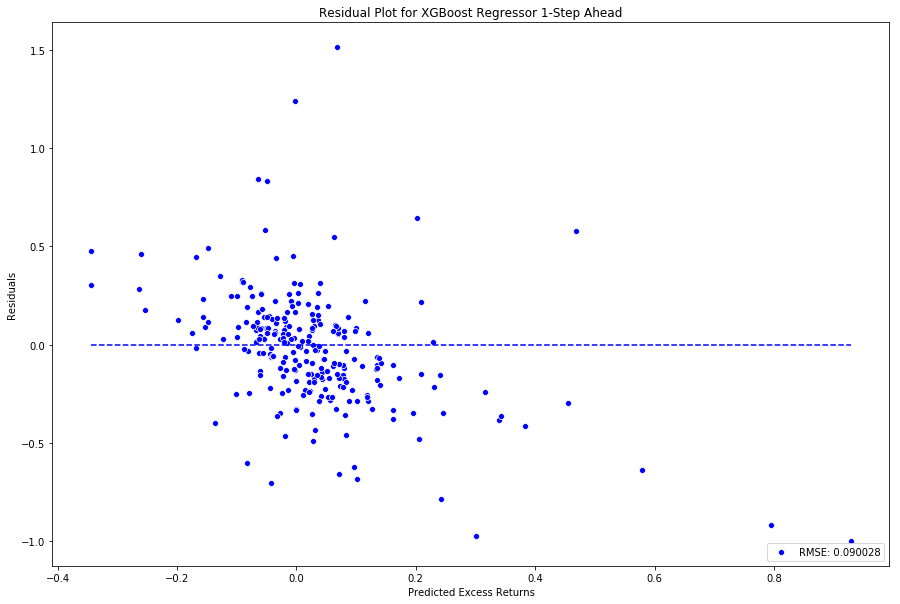

In [183]:
predictions = xg_reg.predict(X_test1)
rmse = MVA(xg_reg, y_train, X_test1, y_test1)
resids = y_test1 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="b", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for XGBoost Regressor 1-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'b')
plt.legend(loc="lower right")
plt.show()

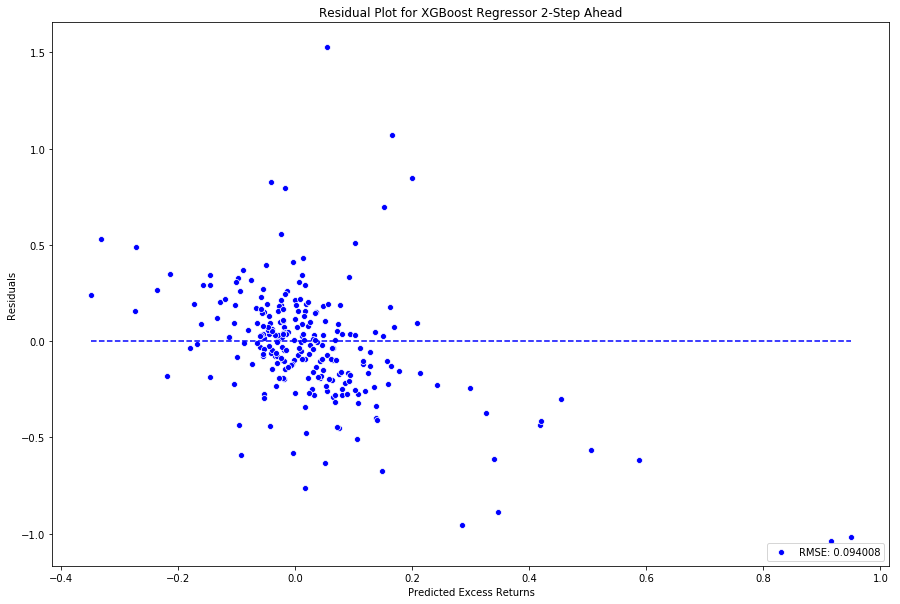

In [184]:
predictions = xg_reg.predict(X_test2)
rmse = MVA(xg_reg, y_train, X_test2, y_test2)
resids = y_test1 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="b", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for XGBoost Regressor 2-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'b')
plt.legend(loc="lower right")
plt.show()

### KNN Regressor

In [89]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = MinMaxScaler(feature_range=(0,1))

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)

X_test1_scaled = scaler.fit_transform(X_test1)
X_test1_scaled = pd.DataFrame(X_test1_scaled)

X_test2_scaled = scaler.fit_transform(X_test2)
X_test2_scaled = pd.DataFrame(X_test2_scaled)

knn_reg = KNeighborsRegressor(n_neighbors=14)

knn_reg.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=14, p=2,
          weights='uniform')

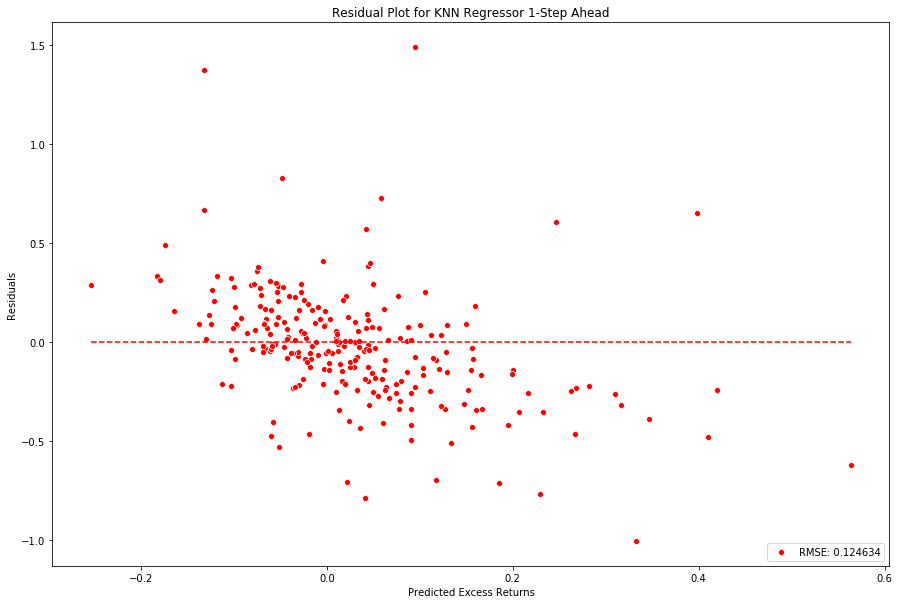

In [187]:
predictions = knn_reg.predict(X_test1)
rmse = MVA(knn_reg, y_train, X_test1, y_test1)
resids = y_test1 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="r", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for KNN Regressor 1-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'r')
plt.legend(loc="lower right")
plt.show()

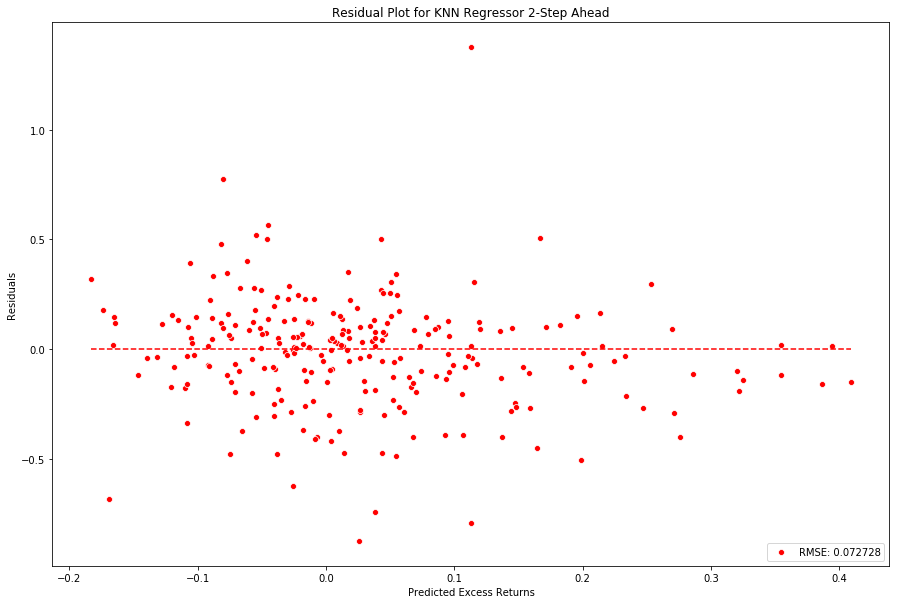

In [189]:
predictions = knn_reg.predict(X_test2)
rmse = MVA(knn_reg, y_train, X_test2, y_test2)
resids = y_test2 - predictions
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.scatterplot(predictions, resids, color="r", 
                label='RMSE: %0.6f' % rmse)
plt.title("Residual Plot for KNN Regressor 2-Step Ahead")
plt.ylabel("Residuals")
plt.xlabel("Predicted Excess Returns")
plt.plot([min(predictions),max(predictions)],[0,0], linestyle="--", color = 'r')
plt.legend(loc="lower right")
plt.show()

# RESULTS

The Random Forest Regressor appears to perform the best with the lowest average RMSE between 1-step-ahead and 2-step-ahead. I go more in-depth about my conclusion in the README in the github repo for this project